## A MNIST dataset classifier using a multilayer perceptron.

In this notebook, i'll try to classify handwriting digits using a multilayer perceptron. The structure consists of input, hidden and output layers with activation functions, i will be using the pytorch framework. The torch module have a lot of useful tools that we can use for this task. To make things easier, the torchvision module will provide datasets, wich already have the MNIST dataset as default, and transforms, for data transformations. Make sure that you have all the libraries needed.

In [1]:
# importing libraries 
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms

In [2]:
#  spliting train and test transformations
train_transform = transforms.Compose([transforms.RandomRotation(10),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                                      ])
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

In [3]:
# Downloading the data
train_set = datasets.MNIST(root='data', train=True, download=True, transform=train_transform)
test_set = datasets.MNIST(root='data', train=False, download=True, transform=test_transform)

In [4]:
train_set # getting some information of the train_set

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: data
    Transforms (if any): Compose(
                             RandomRotation(degrees=(-10, 10), resample=False, expand=False)
                             ToTensor()
                             Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                         )
    Target Transforms (if any): None

In [5]:
# A wise thing to do is leave 20% of the dataset for validation, that helps to avoid overfitting.

In [6]:
batch_size = 64
valid_size = 0.20

In [7]:
 # preparing the validation set
data_points = len(train_set)
indices = list(range(data_points))
np.random.shuffle(indices)
split = int(np.floor(valid_size*data_points))
train_idx, valid_idx = indices[split:], indices[:split]

In [8]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [9]:
train_loader = torch.utils.data.DataLoader(train_set, sampler=train_sampler, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(train_set, sampler=valid_sampler, batch_size=batch_size)
test_loader  = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [10]:
# taking just one batch to get useful info
images, labels = next(iter(train_loader))

In [11]:
# checking the shape of the tensor
images.shape

torch.Size([64, 1, 28, 28])

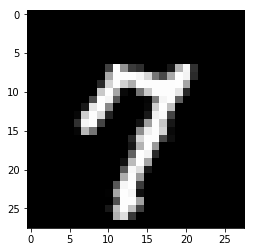

In [12]:
#visualise one image
plt.imshow(np.squeeze(images[3].numpy()), cmap='gray')

In [13]:
# defining the network architecture
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 684) # input
        self.fc2 = nn.Linear(684, 526)     # hidden
        self.fc3 = nn.Linear(526, 10)      # output
    
        # dropout can help avoid overfitting 'turning off' some units
        # during the training
    
        self.dropout = nn.Dropout(p=0.25)
    
    def forward(self, x):
    
        # making sure that our image has the right dimentions
        x = x.view(-1, 28*28)
    
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = F.log_softmax(self.fc3(x), dim=1)
    
        return x

In [14]:
# creating the model, defining loss function and optimizer
model = Network()
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [15]:
# printing information of the model created
print(model)

Network(
  (fc1): Linear(in_features=784, out_features=684, bias=True)
  (fc2): Linear(in_features=684, out_features=526, bias=True)
  (fc3): Linear(in_features=526, out_features=10, bias=True)
  (dropout): Dropout(p=0.25)
)


## Training the model using backpropagation.

In [16]:
epochs = 40
valid_loss_min = np.inf

val, train = [], [] # save the train and validation losses to plot
for ep in range(epochs):
    valid_loss = 0.0
    train_loss = 0.0
  
    model.train() # model on train mode
    for data, target in train_loader:
        optimizer.zero_grad()
    
        output = model(data)
    
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    
        train_loss += loss.item()*data.size(0)
    
    model.eval() # validation mode
    for data, target in valid_loader:
   
        out = model(data)
    
        loss = criterion(out, target)
    
        valid_loss += loss.item()*data.size(0)
    
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
  
    train.append(train_loss)
    val.append(valid_loss)
  
    print('epoch: {} \t train_loss: {:.7f} \t valid_loss: {:.7f}'.format(ep+1, train_loss, valid_loss))
  
    if(valid_loss <= valid_loss_min):
        print('saving model ...\t')
        torch.save(model.state_dict(), 'Modelo_MNIST.pt')# saving the model with the best validation loss
    
        valid_loss_min = valid_loss

epoch: 1 	 train_loss: 0.8877757 	 valid_loss: 0.0987875
saving model ...	
epoch: 2 	 train_loss: 0.3752901 	 valid_loss: 0.0765698
saving model ...	
epoch: 3 	 train_loss: 0.3125709 	 valid_loss: 0.0676745
saving model ...	
epoch: 4 	 train_loss: 0.2783910 	 valid_loss: 0.0624584
saving model ...	
epoch: 5 	 train_loss: 0.2489131 	 valid_loss: 0.0567421
saving model ...	
epoch: 6 	 train_loss: 0.2290469 	 valid_loss: 0.0518274
saving model ...	
epoch: 7 	 train_loss: 0.2086432 	 valid_loss: 0.0476729
saving model ...	
epoch: 8 	 train_loss: 0.1963851 	 valid_loss: 0.0449959
saving model ...	
epoch: 9 	 train_loss: 0.1815124 	 valid_loss: 0.0414227
saving model ...	
epoch: 10 	 train_loss: 0.1675451 	 valid_loss: 0.0395354
saving model ...	
epoch: 11 	 train_loss: 0.1575414 	 valid_loss: 0.0369016
saving model ...	
epoch: 12 	 train_loss: 0.1492893 	 valid_loss: 0.0345962
saving model ...	
epoch: 13 	 train_loss: 0.1392511 	 valid_loss: 0.0330692
saving model ...	
epoch: 14 	 train_los

In [17]:
# this  function will calculate the accuracy of the  model
def accuracy(model, testloader):
    test_loss = 0.0
    correct_classes = list(np.zeros(10))
    all_classes = list(np.zeros(10))
    
    model.eval()
    for data, target in testloader:
        output = model(data)
        loss = criterion(output, target)
    
        test_loss += loss.item()*data.size(0)
    
        prediction = torch.max(output, 1)[1]
        correct = prediction == target
    
    for i in range(target.shape[0]):
        label = target.data[i]
        correct_classes[label] += correct[i].item()
        all_classes[label] += 1
     
    test_loss = test_loss / len(testloader.dataset)
    print('test_loss : {:.6f}'.format(test_loss))
    
  
     
    print('total accuracy : {:.2f}'.format(np.sum(correct_classes) / np.sum(all_classes)))
  

In [18]:
# visualise some predictions
def view(model, testloader):
    images, labels = next(iter(testloader))
    out = model(images)
    pred = torch.max(out, 1)[1]
  
    images = images.numpy()
  
    fig = plt.figure(figsize=(25,4))
    for idx in np.arange(20):
        ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(images[idx]), cmap='gray')
        ax.set_title('it is a : {}'.format(pred[idx].item()))

Text(0.5, 1.0, 'train and validation')

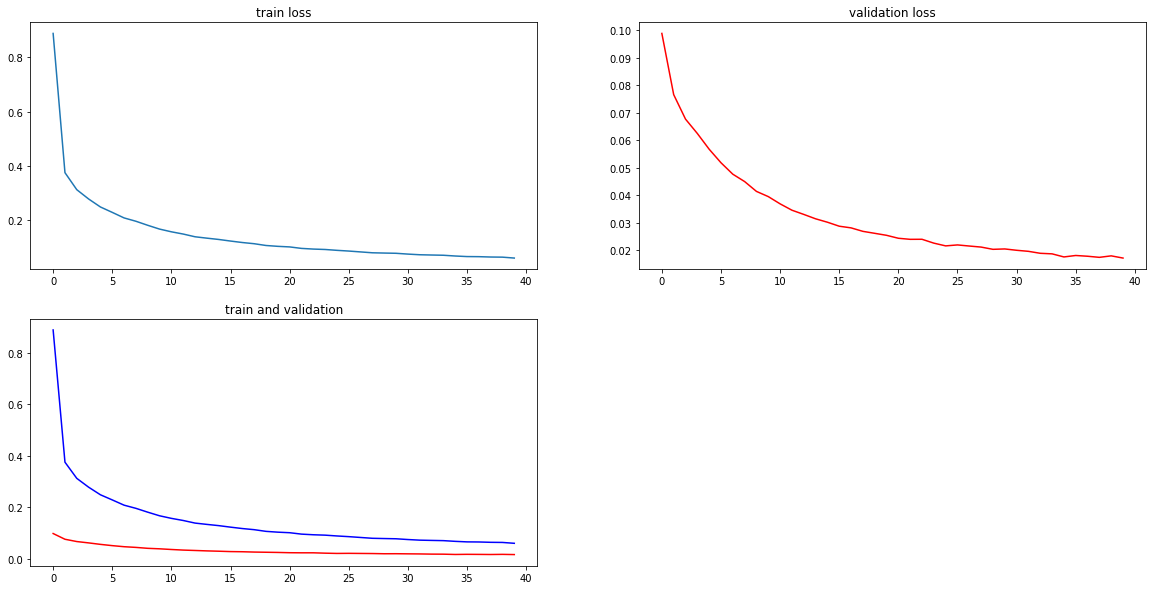

In [19]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(221)
ax.plot(train)
ax.set_title('train loss');
ax = fig.add_subplot(222)
ax.plot(val,'r')
ax.set_title('validation loss',);
ax = fig.add_subplot(223)
ax.plot(train, 'b')
ax.plot(val, 'r')
ax.set_title('train and validation')





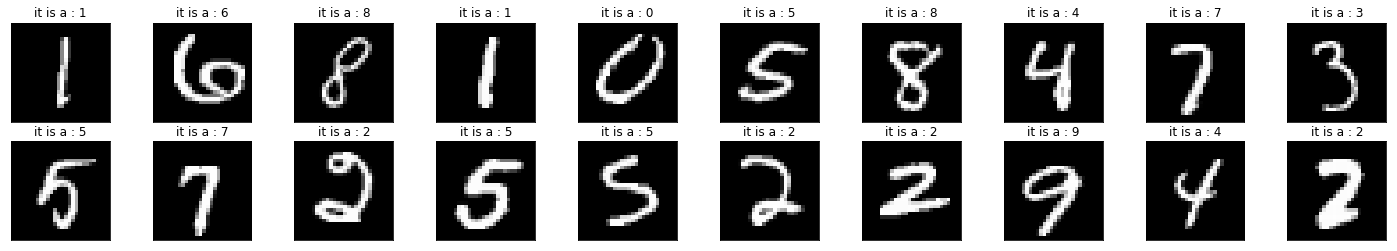

In [20]:
view(model, test_loader)

In [21]:
accuracy(model, test_loader)

test_loss : 0.063399
total accuracy : 0.94
